Выполнила: Анастасия Плавина

# Предсказание статуса соискателя
в рамках проекта предсказания статус соискателя на основе данных кандидатов ([Kaggle](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists))

## Этап 2. Обучение, сохранение и оценка модели

__Структура этапа 2:__

    1. Формирование обучающей и валидационной выборки
    2. Балансировка данных (код оставлен, но результаты отражены только в описании)
    3. Очистка данных и генерация новых признаков
    4. Сборка пайплайна
    5. Обучение бейзлайна по нескольким моделям и анализ метрик
    6. Выбор лучшей модели по метрике
    7. Калибровка модели
    8. Сохранение модели
    9. Интерпретация результатов работы модели

In [1]:
import pandas as pd
import numpy as np
import dill
import itertools


import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, learning_curve
from sklearn.metrics import roc_auc_score, log_loss, f1_score, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

import shap
shap.initjs()
%matplotlib inline

In [2]:
# функции визуализации

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    
    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')   

### 1. Формирование обучающей и валидационной выборки

In [3]:
data = pd.read_csv("train.csv")
target = 'target'
features = data.columns.drop(target).tolist()

x_data = data[features]
y_data = data[target]

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=7)
x_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
14346,2913,city_21,0.624,Male,No relevent experience,no_enrollment,NaN,NaN,1,NaN,NaN,never,61
11553,13483,city_16,0.910,Male,No relevent experience,no_enrollment,Graduate,Humanities,7,NaN,NaN,2,56
16812,6221,city_103,0.920,NaN,Has relevent experience,no_enrollment,High School,NaN,6,100-500,Pvt Ltd,>4,22
16115,18343,city_21,0.624,Male,Has relevent experience,Full time course,Graduate,STEM,10,NaN,NaN,3,180
283,14598,city_37,0.794,NaN,No relevent experience,no_enrollment,Graduate,STEM,9,5000-9999,Pvt Ltd,1,160


### 2. Балансировка

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
# df_for_balancing = pd.concat([x_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, target)
    
# print(df_balanced[target].value_counts())
# x_train = df_balanced.drop(columns=target)
# y_train = df_balanced[target]

### 3. Очистка данных и генерация новых признаков.

Преобразования:
- target encoding, попробовала разные варианты - лучший скор дал энкодинг по медиане таргета;
- добавление колонок со статусом nan;
- приведение опыта работы к числовому формату;
- энкодинг категориальных признаков по численным;
- стандартизация численных признаков;
- обработка категориальных признаков: для моделей без обработка кат. признаков - ohe, для катбуста замена nan на unknown.

In [6]:
class NanFlagger(BaseEstimator, TransformerMixin):
    """creating nan-flags for columns with nan-values"""
    def __init__(self, key=None):
        self.key = key
        self.mode = None

    def fit(self, X, y=None):
        self.mode = X[self.key].mode()[0]
        return self

    def transform(self, X):
        data = X.copy()
        ## делаем колонки для нанов 
        data[self.key+'_is_nan'] = 0
        data.loc[X[self.key].isna(), f'{self.key}_is_nan'] = 1
        data[self.key].fillna(self.mode, inplace=True)      
        return data[[self.key+'_is_nan']]
    
class TargetEncoder(BaseEstimator, TransformerMixin):
    """encoding target by median for categorical features"""
    def __init__(self, key=None):
        self.key = key
        self.encoder = None
        self.mode = None
        
    def fit(self, X, y=None):
        self.mode = X[self.key].mode()[0]
        data = X.copy()
        data['target'] = y.values
        data[self.key].fillna(self.mode, inplace=True)
        data_encoded = data.groupby(self.key)['target'].median().reset_index()
        data_encoded.rename(columns={target: f'{self.key}_target_median'}, inplace=True)
        self.encoder = data_encoded
        return self
    
    def transform(self, X):
        data = X.copy()
        data[self.key].fillna(self.mode, inplace=True)
        data = data.merge(self.encoder, on=self.key)
        return data[[f'{self.key}_target_median']]
      
class NanReplacerForCats(BaseEstimator, TransformerMixin):
    """replacing nans to Unknown"""
    def __init__(self, key=None):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        ## Заменяем nan на unknown для catboost
        data.loc[X[self.key].isna(), self.key] = 'Unknown'
        return data[[self.key]]
    
class FeatureGenerator(BaseEstimator, TransformerMixin):
    """creating new features - binary and num.features encoding"""
    def __init__(self, key=None):
        self.key = key
        self.gender_mode = None
        self.enrolled_university_mode = None
        self.education_level_mode = None
        self.major_discipline_mode = None
        self.experience_mode = None
        self.company_size_mode = None
        self.company_type_mode = None
        self.last_new_job_mode = None

    def fit(self, X, y=None):
        self.gender_mode = X['gender'].mode()[0]
        self.enrolled_university_mode = X['enrolled_university'].mode()[0]
        self.education_level_mode = X['education_level'].mode()[0]
        self.major_discipline_mode = X['major_discipline'].mode()[0]
        self.experience_mode = X['experience'].mode()[0]
        self.company_size_mode = X['company_size'].mode()[0]
        self.company_type_mode = X['company_type'].mode()[0]
        self.last_new_job_mode = X['last_new_job'].mode()[0]
        
        return self

    def transform(self, X):
        data = X.copy()
        ## Заменяем пропуски
        data['gender'].fillna(self.gender_mode, inplace=True)
        data['enrolled_university'].fillna(self.enrolled_university_mode, inplace=True)
        data['education_level'].fillna(self.education_level_mode, inplace=True)
        data['major_discipline'].fillna(self.major_discipline_mode, inplace=True)
        data['experience'].fillna(self.experience_mode, inplace=True)
        data['company_size'].fillna(self.company_size_mode, inplace=True)
        data['company_type'].fillna(self.company_type_mode, inplace=True)
        data['last_new_job'].fillna(self.last_new_job_mode, inplace=True)
        data['experience_int'] = data['experience']
        data.loc[data['experience'] == '>20', 'experience_int'] = 25
        data.loc[data['experience'] == '<1', 'experience_int'] = 0
        data['experience_int'] = data['experience_int'].astype(int)
        
        cols_to_agg_by = ['city','gender','relevent_experience','enrolled_university','education_level',
                          'major_discipline','company_size','company_type','last_new_job']

        # берем среднее по кат. фичам
        for feat in cols_to_agg_by:

            data_grp = data.groupby(feat)[['training_hours', 'city_development_index']].mean().reset_index()
            data_grp.rename(columns={'training_hours': f'{feat}_training_hours_mean', 
                                    'city_development_index': f'{feat}_city_development_index_mean'}, inplace=True)
            data = data.merge(data_grp, on=feat)
            
        # бинарный - есть образование, нет образования
        data['enrolled_university_binary'] = data['enrolled_university'] \
                                .replace(['no_enrollment', 'Full time course', 'Part time course'], [0, 1, 1])
    
        # бинарный - есть опыт, нет опыта
        data['relevent_experience_binary'] = data['relevent_experience'] \
                                .replace(['Has relevent experience', 'No relevent experience'], [1, 0])
        

        new_cols = ['experience_int', 'city_training_hours_mean',
       'city_city_development_index_mean', 'gender_training_hours_mean',
       'gender_city_development_index_mean',
       'relevent_experience_training_hours_mean',
       'relevent_experience_city_development_index_mean',
       'enrolled_university_training_hours_mean',
       'enrolled_university_city_development_index_mean',
       'education_level_training_hours_mean',
       'education_level_city_development_index_mean',
       'major_discipline_training_hours_mean',
       'major_discipline_city_development_index_mean',
       'company_size_training_hours_mean',
       'company_size_city_development_index_mean',
       'company_type_training_hours_mean',
       'company_type_city_development_index_mean',
       'last_new_job_training_hours_mean',
       'last_new_job_city_development_index_mean']
        
        # стандартизуем
        scaler = StandardScaler()
        scaler.fit(data[new_cols])
        data[new_cols] = scaler.transform(data[new_cols])
        
        return data[new_cols + ['enrolled_university_binary', 'relevent_experience_binary']]
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    """selecting a feature"""
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[[self.column]]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    """dummies for cat features"""
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

### 4. Сборка пайплайна

In [7]:
continuous_columns = list(data.drop(target, axis=1).select_dtypes(['float', 'int']).columns)
categorical_columns = list(data.select_dtypes('object').columns)

final_transformers = list()

# делаем ohe влоб (не очень хорошо для некоторых признаков, т.к. много категорий), 
# чтобы передать в модель все признаки, далее будем смотреть результаты catboost
for cat_col in categorical_columns:
    cat_ohe_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('OHE', OHEEncoder(cat_col))
            ])
    final_transformers.append((cat_col+'_ohe', cat_ohe_transformer))


for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler(cont_col))
            ])

    final_transformers.append((cont_col, cont_transformer))

# добавляем таргет энкодинг 
for cat_col in categorical_columns:
    encoder = Pipeline([
                ('selector', FeatureSelector(column=cat_col)), 
                ('encoder', TargetEncoder(cat_col))
            ])
    final_transformers.append((cat_col+'encoder', encoder))



nan_cols = ['enrolled_university', 'education_level', 'major_discipline', 
                    'experience', 'company_size', 'company_type', 'last_new_job']

# # флаги нанов
for nan_col in nan_cols:
    nan_transformer = Pipeline([
                ('selector', FeatureSelector(column=nan_col)), 
                ('nan', NanFlagger(nan_col))
            ])
    final_transformers.append((nan_col, nan_transformer))
    

# новые признаки
gen_transformer = Pipeline([
                ('generator', FeatureGenerator())
            ])
final_transformers.append(('gen', gen_transformer))


feats = FeatureUnion(final_transformers)


# список колонок ohe
all_vars = []
for col in categorical_columns:
    for val in list(data[data[col].notna()][col].unique()):
        name = f'{col}_{val}'
        all_vars.append(name)
        

# соберем все названия колонок для feature_importance
all_cols = all_vars + continuous_columns + \
            [col+'_target_median' for col in categorical_columns] + [col+'_is_nan' for col in nan_cols] + \
            ['experience_int', 'city_training_hours_mean',
            'city_city_development_index_mean', 'gender_training_hours_mean',
            'gender_city_development_index_mean',
            'relevent_experience_training_hours_mean',
            'relevent_experience_city_development_index_mean',
            'enrolled_university_training_hours_mean',
            'enrolled_university_city_development_index_mean',
            'education_level_training_hours_mean',
            'education_level_city_development_index_mean',
            'major_discipline_training_hours_mean',
            'major_discipline_city_development_index_mean',
            'company_size_training_hours_mean',
            'company_size_city_development_index_mean',
            'company_type_training_hours_mean',
            'company_type_city_development_index_mean',
            'last_new_job_training_hours_mean',
            'last_new_job_city_development_index_mean', 
            'enrolled_university_binary', 'relevent_experience_binary']


len(all_cols)

225

###  5. Обучение бейзлайна по нескольким моделям и анализ метрик

#### Обучение

In [8]:
results = {
    'classifier': [], 
    'rocauc': [], 
    'logloss': [], 
    'F-Score': [], 
    'Precision': [], 
    'Recall': []
}

model_names = ['RandomForest', 'GradientBoosting', 'lgbm', 'xgb']
models = [RandomForestClassifier(random_state = 42), 
          GradientBoostingClassifier(random_state=42), lgbm.LGBMClassifier(random_state=42),
          xgb.XGBClassifier(random_state=42)]


def learning_pipline(classifier):
    pipeline = Pipeline([
        ('features',feats),
        ('classifier', classifier),
    ])

    classifier = pipeline.fit(x_train, y_train)
    
    return classifier

--------------------------------------------------------------------------------------
1 RandomForest
Best Threshold=0.330000, F-Score=0.635, Precision=0.566, Recall=0.721
classification_report

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85      2845
         1.0       0.57      0.72      0.63       987

    accuracy                           0.79      3832
   macro avg       0.73      0.76      0.74      3832
weighted avg       0.81      0.79      0.79      3832



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


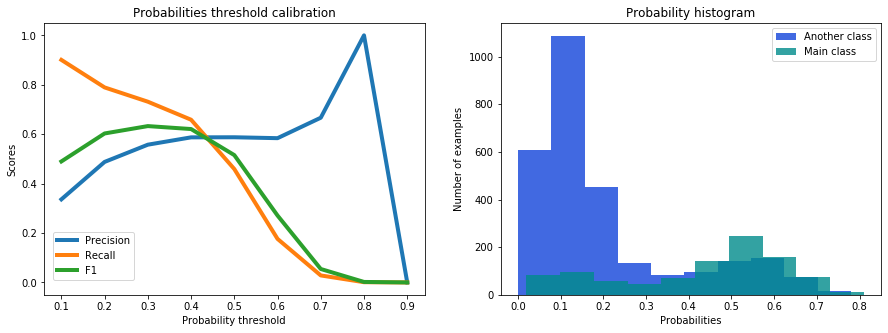

Confusion matrix, without normalization


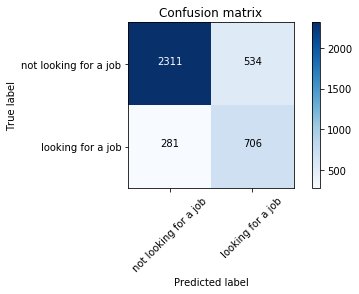

--------------------------------------------------------------------------------------
2 GradientBoosting


invalid value encountered in true_divide
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Best Threshold=0.757105, F-Score=nan, Precision=0.000, Recall=0.000
classification_report

              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85      2845
         1.0       0.00      0.00      0.00       987

    accuracy                           0.74      3832
   macro avg       0.37      0.50      0.43      3832
weighted avg       0.55      0.74      0.63      3832



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


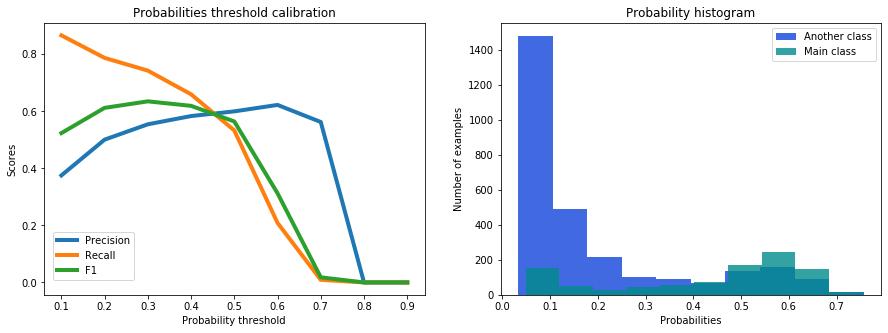

Confusion matrix, without normalization


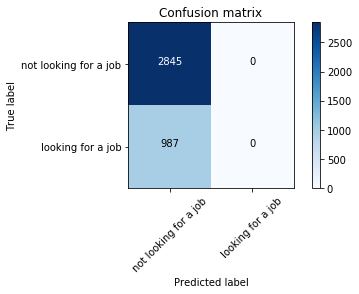

--------------------------------------------------------------------------------------
3 lgbm
Best Threshold=0.319886, F-Score=0.645, Precision=0.581, Recall=0.724
classification_report

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86      2845
         1.0       0.58      0.72      0.64       987

    accuracy                           0.79      3832
   macro avg       0.74      0.77      0.75      3832
weighted avg       0.81      0.79      0.80      3832



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


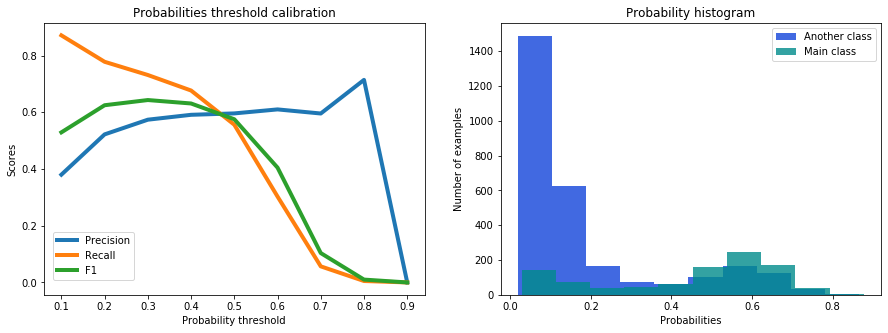

Confusion matrix, without normalization


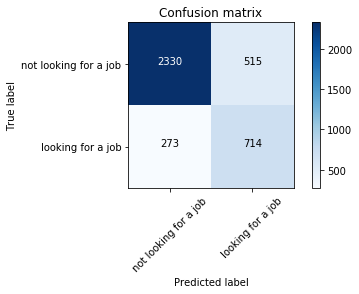

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:57:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
--------------------------------------------------------------------------------------
4 xgb
Best Threshold=0.308318, F-Score=0.617, Precision=0.561, Recall=0.685
classification_report

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.85      2845
         1.0       0.56      0.68      0.62       987

    accuracy                           0.78      3832
   macro avg       0.72      0.75      0.73      3832
weighted avg       0.80      0.78      0.79      3832



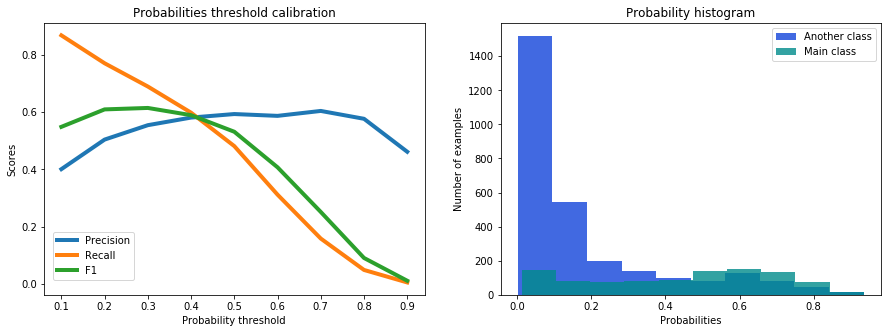

Confusion matrix, without normalization


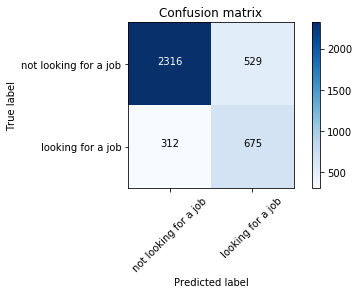

In [9]:
### Анализ метрик

for i in range(len(models)):
    classifier = learning_pipline(models[i])
    print('--------------------------------------------------------------------------------------')
    print(i+1, model_names[i])
    results['classifier'].append(model_names[i])
    preds = classifier.predict_proba(x_val)[:, 1]
    

    precision, recall, thresholds = precision_recall_curve(y_val, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    
    rocauc = roc_auc_score(y_true=y_val, y_score=preds)
    logloss = log_loss(y_true=y_val, y_pred=preds)
    
    results['rocauc'].append(rocauc)
    results['logloss'].append(logloss)
    results['F-Score'].append(fscore[ix])
    results['Precision'].append(precision[ix])
    results['Recall'].append(recall[ix])
    
    print('classification_report\n\n' + classification_report(y_val, preds>thresholds[ix]))
    show_proba_calibration_plots(preds, y_val)
    
    plot_confusion_matrix(confusion_matrix(y_val, preds>thresholds[ix]), 
                          classes=['not looking for a job', 'looking for a job'], title='Confusion matrix')
    plt.show()

#### Анализ метрик бейзлайна

Выполнено обучение нескольких алгоритмов без новых признаков и дополнительной обработки пропусков (выводы сжаты до текста во избежание повторения кода, визуализация выше относится уже в итоговому пайплайну с доп. обработками). 

- Оценка f-score целевого класса (1):

- random forest - 0.56

- GradientBoosting - 0.00 (не учится)

- lgbm - 0.60 

- xgb - 0.00 (не учится)


Далее сделала **балансировку** - результаты не сильно улучшились, но стал работать xgb и бустинг, но отказался учиться с балансировкой lgbm.

Оценка f-score целевого класса (1):

- random forest - 0.55

- GradientBoosting - 0.60

- lgbm - 0.00 (не учится)

- xgb - 0.59


В целом результаты балансировки не однозначные - поднять скор не получилось, но можно сменить алгоритм.

#### Анализ результатов после обработки признаков без балансировки, т.к. хочется посмотреть как сработает lgbm, который справился лучше всего на бейзлайне

Оценка f-score целевого класса (1):

- RandomForest -  0.00 не обучился (таргет энкодинг по медиане повлиял негативно)

- GradientBoosting - 0.637

- lgmb - 0.645

- xgb - 0.62

LGBM оправдал ожидания, подняли метрику. Дальше посмотрим на на работу catboost

#### Обучение catboost для максимальной оптимизации обработки категориальных признаков.
Немного изменим пайплайн, т.к. будем смотреть на изначальные кат.фичи

In [10]:
final_transformers_cat = list()

# берем преобразованную фичу с unknown вместо nan
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('nan_replacer', NanReplacerForCats(cat_col))
        
            ])
    final_transformers_cat.append((cat_col+'_orig', cat_transformer))

    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler(cont_col))
            ])

    final_transformers_cat.append((cont_col, cont_transformer))

    
for cat_col in categorical_columns:
    data[cat_col] = data[cat_col].astype('category')
    encoder = Pipeline([
                ('selector', FeatureSelector(column=cat_col)), 
                ('encoder', TargetEncoder(cat_col))
            ])
    final_transformers_cat.append((cat_col+'encoder', encoder))

    
    
for nan_col in nan_cols:
    nan_transformer = Pipeline([
                ('selector', FeatureSelector(column=nan_col)), 
                ('nan', NanFlagger(nan_col))
            ])
    final_transformers_cat.append((nan_col, nan_transformer))

# новые признаки
gen_transformer = Pipeline([
                ('generator', FeatureGenerator())
            ])
final_transformers_cat.append(('gen', gen_transformer))

feats_cat = FeatureUnion(final_transformers_cat)

# соберем все названия колонок для feature_importance
all_cols_cat = categorical_columns + all_cols
len(all_cols_cat)

235

Здесь зададим веса классов

catboost
--------------------------------------------------------------------------------------
Best Threshold=0.133669, F-Score=0.640, Precision=0.567, Recall=0.734
classification_report

              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85      2845
         1.0       0.57      0.73      0.64       987

    accuracy                           0.79      3832
   macro avg       0.73      0.77      0.74      3832
weighted avg       0.81      0.79      0.79      3832



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


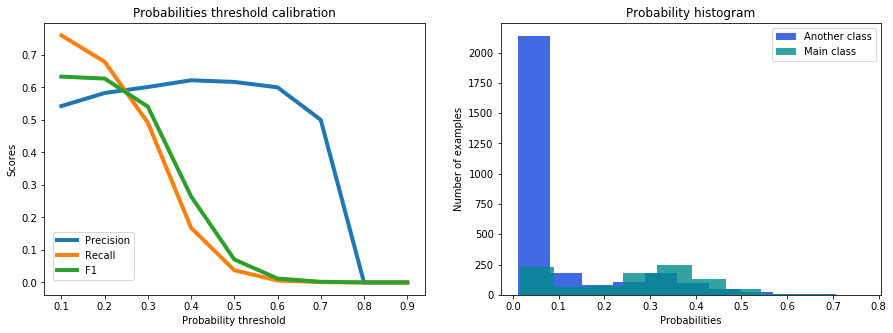

Confusion matrix, without normalization


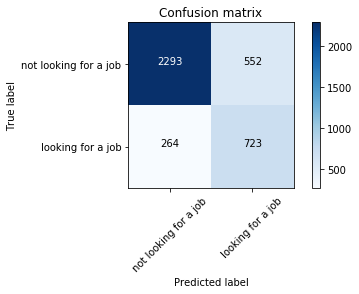

CPU times: user 1min 48s, sys: 12.1 s, total: 2min
Wall time: 45.8 s


In [12]:
%%time

pipeline = Pipeline([
        ('features', feats_cat),
        ('classifier', catb.CatBoostClassifier(random_state=42, silent=True, class_weights=[0.75, 0.25], 
                                  cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])),
    ])

classifier = pipeline.fit(x_train, y_train)
print('catboost')
print('--------------------------------------------------------------------------------------')
results['classifier'].append('catboost')
preds = classifier.predict_proba(x_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                    fscore[ix],
                                                                    precision[ix],
                                                                    recall[ix]))

rocauc = roc_auc_score(y_true=y_val, y_score=preds)
logloss = log_loss(y_true=y_val, y_pred=preds)

results['rocauc'].append(rocauc)
results['logloss'].append(logloss)
results['F-Score'].append(fscore[ix])
results['Precision'].append(precision[ix])
results['Recall'].append(recall[ix])

print('classification_report\n\n' + classification_report(y_val, preds>thresholds[ix]))
show_proba_calibration_plots(preds, y_val)


plot_confusion_matrix(confusion_matrix(y_val, preds>thresholds[ix]), classes=['not looking for a job', 
                                                                               'looking for a job'],
                      title='Confusion matrix')
plt.show()

### 6. Выбор лучшей модели

In [13]:
df_results = pd.DataFrame(results).sort_values('F-Score', axis=0, ascending=False).reset_index(drop=True)
df_results

,classifier,rocauc,logloss,F-Score,Precision,Recall
0,lgbm,0.801191,0.444334,0.645016,0.581301,0.724417
1,catboost,0.800431,0.510884,0.639859,0.567398,0.733536
2,RandomForest,0.794633,0.452329,0.634581,0.566428,0.721378
3,xgb,0.796050,0.464855,0.616788,0.560996,0.684904
4,GradientBoosting,0.795628,0.448069,NaN,0.000000,0.000000


С lgbm получаем наилучший результат и по f1 и по roc-auc не смотря на преобладание кат.фич, которые в lgmb обработаны достаточно грубо.

### 7. Калибровка лучшей модели

In [14]:
params = {
'n_estimators': [50, 100, 200, 300, 400, 500],
'min_samples_leaf': np.arange(10, 50, step=5),
'max_depth': np.arange(5, 50, step=5)
}

cv=KFold(n_splits=3, random_state=42, shuffle=True)

In [15]:
# %%time

# x_train = feats.transform(x_train)

# gscv = GridSearchCV(lgbm.LGBMClassifier(random_state=42), params, scoring='f1', cv=cv, n_jobs=-1)
# gscv.fit(x_train, y_train)

# gscv.best_params_

In [16]:
calibrated_pipeline = Pipeline([
        ('features',feats),
        ('classifier', lgbm.LGBMClassifier(random_state=42, n_estimators=50, min_samples_leaf=10, max_depth=20)),
    ])

classifier = calibrated_pipeline.fit(x_train, y_train)
print('lgbm_calibrated')
print('--------------------------------------------------------------------------------------')
results['classifier'].append('lgbm_calibrated')
preds = classifier.predict_proba(x_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                    fscore[ix],
                                                                    precision[ix],
                                                                    recall[ix]))

rocauc = roc_auc_score(y_true=y_val, y_score=preds)
logloss = log_loss(y_true=y_val, y_pred=preds)

results['rocauc'].append(rocauc)
results['logloss'].append(logloss)
results['F-Score'].append(fscore[ix])
results['Precision'].append(precision[ix])
results['Recall'].append(recall[ix])

lgbm_calibrated
--------------------------------------------------------------------------------------
Best Threshold=0.331991, F-Score=0.645, Precision=0.583, Recall=0.722


In [17]:
df_results = pd.DataFrame(results).sort_values('F-Score', axis=0, ascending=False).reset_index(drop=True)
df_results

,classifier,rocauc,logloss,F-Score,Precision,Recall
0,lgbm_calibrated,0.800425,0.440894,0.645249,0.582993,0.722391
1,lgbm,0.801191,0.444334,0.645016,0.581301,0.724417
2,catboost,0.800431,0.510884,0.639859,0.567398,0.733536
3,RandomForest,0.794633,0.452329,0.634581,0.566428,0.721378
4,xgb,0.796050,0.464855,0.616788,0.560996,0.684904
5,GradientBoosting,0.795628,0.448069,NaN,0.000000,0.000000


### 8. Сохранение модели

In [18]:
with open("../lgbm_pipeline.dill", "wb") as f:
    dill.dump(calibrated_pipeline, f)

### 9. Интерпретация результатов

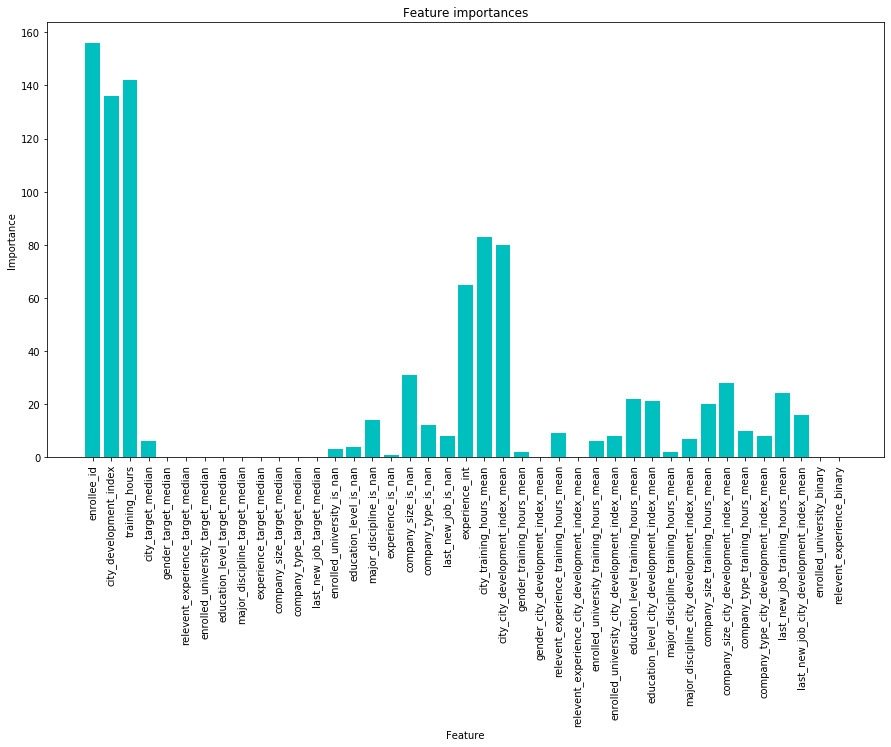

In [19]:
importances = classifier[1].feature_importances_[184:] # без ohe
plt.figure(figsize = [15, 8])
plt.bar(all_cols[184:], importances, color='c')
plt.title('Feature importances')
plt.xlabel('Feature')
plt.xticks(rotation = 90)
plt.ylabel('Importance')
plt.show()

Достаточно поверхностная калибровка дала небольшое улучшиение f1. По важности признаков видим количественные признаки, которые показали корреляцию с таргетом, очисленный опыт работы, колонка статуса нана для размера компании, где много пропусков, а также два численных энкодинга - среднее число часов обучения по городу (этот показатель вполне может быть связан с состояние рынка труда, а, значит, может оказывать влияние на желание и возможность движения персонала на рынке труда) и средний индекс развития по городу (это, по-видимому, средний индекс города, если он динамически менялся по ходу попоплнения базы). 

In [20]:
# преобразуем трейн + переводим в df
x_train_shap = pd.DataFrame(feats.fit_transform(x_train, y_train), 
                            columns=all_cols)

explainer = shap.TreeExplainer(calibrated_pipeline[1])
shap_values = explainer.shap_values(x_train_shap)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### Топ важных признаков

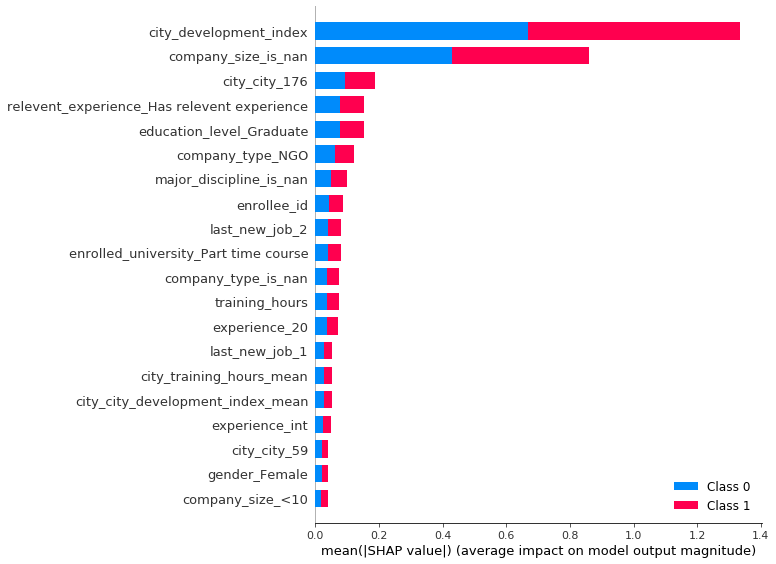

In [21]:
shap.summary_plot(shap_values, x_train_shap)

Видно, что признак индекс развития города дал очень хорошее разделение классов для модели. Несколько ohe-фич тоже улучшили разделимость - статус образования, наличие релевантного опыта, работа в некоммерческой организации, отсутствие данных об основном предмете (либо можем предположить его отсутсвие - т.е. человек либо не получал высшее образование, либо еще учится, следовательно не находится в поиске.